In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
warnings.simplefilter('ignore')

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()

In [4]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "results"
    device: str = "cuda:0"

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    imgdir_name: str = "../../data/VinBigData/png256"
    seed: int = 111
    n_splits: int = 10
    label_smoothing: float = 1e-2
    
    # Model config
    model_name: str = "resnet18"
    model_mode: str = "normal"  # normal, cnn_fixed supported
        
    # Training config
    epoch: int = 20
    lr: float = 1e-3
    lr_decay: float = 0.9
    batchsize: int = 8
    valid_batchsize: int = 16
    patience: int = 3
    num_workers: int = 4
    snapshot_freq: int = 5
    scheduler_type: str = ""
    scheduler_kwargs: Dict[str, Any] = field(default_factory=lambda: {})
    aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    mixup_prob: float = 0.
    oversample: bool = True

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [5]:
import torch, torchvision
import torch
assert torch.__version__.startswith("1.7")
from detectron2.structures import BoxMode


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts

In [6]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


import cv2
import numpy as np


class VinbigdataTwoClassDataset(DatasetMixin):
    def __init__(self, dataset_dicts, image_transform=None, transform=None, train: bool = True,
                 mixup_prob: float = -1.0, label_smoothing: float = 0.0):
        super(VinbigdataTwoClassDataset, self).__init__(transform=transform)
        self.dataset_dicts = dataset_dicts
        self.image_transform = image_transform
        self.train = train
        self.mixup_prob = mixup_prob
        self.label_smoothing = label_smoothing

    def _get_single_example(self, i):
        d = self.dataset_dicts[i]
        filename = d["file_name"]

        img = cv2.imread(filename)
        if self.image_transform:
            img = self.image_transform(img)
        img = torch.tensor(np.transpose(img, (2, 0, 1)).astype(np.float32))

        if self.train:
            label = int(len(d["annotations"]) > 0)  # 0 normal, 1 abnormal
            if self.label_smoothing > 0:
                if label == 0:
                    return img, float(label) + self.label_smoothing
                else:
                    return img, float(label) - self.label_smoothing
            else:
                return img, float(label)
        else:
            # Only return img
            return img, None

    def get_example(self, i):
        img, label = self._get_single_example(i)
        if self.mixup_prob > 0. and np.random.uniform() < self.mixup_prob:
            j = np.random.randint(0, len(self.dataset_dicts))
            p = np.random.uniform()
            img2, label2 = self._get_single_example(j)
            img = img * p + img2 * (1 - p)
            if self.train:
                label = label * p + label2 * (1 - p)

        if self.train:
            label_logit = torch.tensor([1 - label, label], dtype=torch.float32)
            return img, label_logit
        else:
            # Only return img
            return img

    def __len__(self):
        return len(self.dataset_dicts)

In [7]:
config_dict = {
    "debug": False,
    # Data config
    "n_splits": 5,
    "label_smoothing": 0,
    # Model
    "model_name": "resnet18",
    # Training
    "num_workers": 4,
    "epoch": 25,
    "batchsize": 32,
    "lr": 1e-3,
    "lr_decay": 0.9,
    "patience": 5,
    "scheduler_type": "CosineAnnealingWarmRestarts",
    "scheduler_kwargs": {"T_0": 7032, 'verbose': True},  # 15000 * 15 epoch // (batchsize=8)
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CoarseDropout": {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5},
        "Blur": {"blur_limit": [3, 7], "p": 0.5},
        "Downscale": {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3},
        "RandomGamma": {"gamma_limit": [80, 120], "p": 0.6},
#         "Normalize": {},
    },
    "mixup_prob": 0,
    "oversample": False,
}

config = Config().update(config_dict)

In [8]:
config.to_yaml(str(base_dir / config.outdir / 'cofig.yaml'))
config

Config(debug=False, outdir='results', device='cuda:0', imgconf_file='../../data/VinBigData/train.csv', imgdir_name='../../data/VinBigData/png256', seed=111, n_splits=5, label_smoothing=0, model_name='resnet18', model_mode='normal', epoch=25, lr=0.0001, lr_decay=0.9, batchsize=32, valid_batchsize=16, patience=5, num_workers=4, snapshot_freq=5, scheduler_type='CosineAnnealingWarmRestarts', scheduler_kwargs={'T_0': 7032, 'verbose': True}, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'CoarseDropout': {'max_holes': 8, 'max_height': 25, 'max_width': 25, 'p': 0.5}, 'Blur': {'blur_limit': [3, 7], 'p': 0.5}, 'Downscale': {'scale_min': 0.25, 'scale_max': 0.9, 'p': 0.3}, 'RandomGamma': {'gamma_limit': [80, 120], 'p': 0.6}}, mixup_prob=0, oversample=False)

In [9]:
train = pd.read_csv(str(base_dir / config.imgconf_file))
dataset_dicts = get_vinbigdata_dicts(base_dir / config.imgdir_name, train, debug=config.debug)

Creating data...
image shape: (256, 256, 3)


  0%|          | 0/15000 [00:00<?, ?it/s]

Load from cache dataset_dicts_cache_original_debug0.pkl


In [10]:
skf = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=config.seed)
y = np.array([int(len(d["annotations"]) > 0) for d in dataset_dicts])
split_inds = list(skf.split(dataset_dicts, y))

fold = 0
train_inds, valid_inds = split_inds[fold]  # 0th fold

train_dataset = VinbigdataTwoClassDataset(
    [dataset_dicts[i] for i in train_inds],
    image_transform=Transform(config.aug_kwargs),
    mixup_prob=config.mixup_prob,
    label_smoothing=config.label_smoothing,
)
valid_dataset = VinbigdataTwoClassDataset([dataset_dicts[i] for i in valid_inds])

Text(0.5, 1.0, '0-th image: label tensor([0., 1.])')

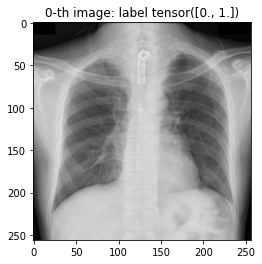

In [11]:
index = 0
img, label = valid_dataset[index]
plt.imshow(img.cpu().numpy().transpose((1, 2, 0)) / 255.)
plt.title(f"{index}-th image: label {label}")

In [12]:
import dataclasses
import pytorch_pfn_extras.training.extensions as E
import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from ignite.engine import Events, Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import EarlyStopping
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.param_scheduler import LRScheduler
from ignite.contrib.metrics import AveragePrecision

In [13]:
def score_function(engine):
    """
    Due to maximizing score_function, this returns (-1) x loss
    """
    val_loss = engine.state.metrics['BCE']
    return -val_loss


def discreted_output_transform(output):
    y_pred, y = output
    y_pred = torch.argmax(y_pred, dim=-1)
    y = torch.argmax(y, dim=-1)
    return y_pred, y


def probability_output_transform(output):
    y_pred, y = output
    y_pred = torch.softmax(y_pred, dim=1)[:, 1]
    y = torch.argmax(y, dim=1)
    return y_pred, y


def train(epochs: int, model: nn.Module, train_loader: DataLoader, valid_loader: DataLoader, criterion: Callable,
          device: str, lr: float, patience: int, lr_decay: float, lr_scheduler: str, lr_scheduler_kwargs: Dict[str, Any]):
    
    model.to(torch.device(device))
    optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=lr)
    
    trainer = create_supervised_trainer(
        model, 
        optimizer, 
        criterion, 
        device=device
    )
    
    scheduler = LRScheduler(getattr(optim.lr_scheduler, lr_scheduler)(optimizer, **lr_scheduler_kwargs))
    trainer.add_event_handler(Events.ITERATION_COMPLETED, scheduler)
    
    pbar = ProgressBar(False)
    pbar.attach(trainer)
    
    train_evaluator = create_supervised_evaluator(
        model,
        metrics={'ACC': Accuracy(discreted_output_transform), 'BCE': Loss(criterion), 'AP': AveragePrecision(probability_output_transform)},
        device=device
    )
    valid_evaluator = create_supervised_evaluator(
        model,
        metrics={'ACC': Accuracy(discreted_output_transform), 'BCE': Loss(criterion), 'AP': AveragePrecision(probability_output_transform)},
        device=device
    )
    
    history = {col: list() for col in ['epoch', 'elapsed time', 'iterations', 'lr', 'train BCE', 'valid BCE', 'train ACC', 'valid ACC', 'train AP', 'valid AP']}

    
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        
        history['train BCE'] += [train_evaluator.state.metrics['BCE']]
        history['train ACC'] += [train_evaluator.state.metrics['ACC']]
        history['train AP'] += [train_evaluator.state.metrics['AP']]
        
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        valid_evaluator.run(valid_loader)
        
        history['epoch'] += [valid_evaluator.state.epoch]
        history['iterations'] += [valid_evaluator.state.epoch_length]
        history['elapsed time'] += [0 if len(history['elapsed time']) == 0 else history['elapsed time'][-1] + valid_evaluator.state.times['COMPLETED']]
        history['lr'] += [scheduler.get_param()]
        
        history['valid BCE'] += [valid_evaluator.state.metrics['BCE']]
        history['valid ACC'] += [valid_evaluator.state.metrics['ACC']]
        history['valid AP'] += [valid_evaluator.state.metrics['AP']]
        
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_progress_bar(engine):
        pbar.log_message(
            f"train BCE: {history['train BCE'][-1]:.2f} " \
            + f"train ACC: {history['train ACC'][-1]:.2f} " \
            + f"train AP: {history['train AP'][-1]:.2f} " \
            + f"valid BCE: {history['valid BCE'][-1]:.2f} " \
            + f"valid ACC: {history['valid ACC'][-1]:.2f} " \
            + f"valid AP: {history['valid AP'][-1]:.2f}"
        )
                
    
    # Early stopping
    handler = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
    valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)

    trainer.run(train_loader, max_epochs=epochs)
    return pd.DataFrame(history)

In [14]:
seed_everything(seed=config.seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batchsize,
    num_workers=config.num_workers,
    shuffle=True,
    pin_memory=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.valid_batchsize,
    num_workers=config.num_workers,
    shuffle=False,
    pin_memory=True,
)


predictor = build_predictor(model_name=config.model_name, model_mode=config.model_mode)
model = Classifier(predictor)

history_df = train(
    epochs=config.epoch, 
    model=model,
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    criterion=cross_entropy_with_logits,
    device=config.device,
    lr=config.lr,
    lr_decay=config.lr_decay,
    patience=config.patience,
    lr_scheduler=config.scheduler_type,
    lr_scheduler_kwargs=config.scheduler_kwargs
)

os.mkdir(str(base_dir / config.outdir / f'fold-{fold + 1}'))
history_df.to_csv(str(base_dir / config.outdir / f'fold-{fold + 1}' / 'history.csv'))
torch.save(model.state_dict(), str(base_dir / config.outdir / f'fold-{fold + 1}' / 'model_last.pt'))

del model, predictor, history_df, train_dataset, valid_dataset, train_loader, valid_loader
gc.collect()

Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.


[1/375]   0%|           [00:00<?]

train BCE: 0.29 train ACC: 0.88 train AP: 0.89 valid BCE: 0.22 valid ACC: 0.91 valid AP: 0.93


[1/375]   0%|           [00:00<?]

train BCE: 0.23 train ACC: 0.91 train AP: 0.94 valid BCE: 0.20 valid ACC: 0.92 valid AP: 0.95


[1/375]   0%|           [00:00<?]

train BCE: 0.19 train ACC: 0.92 train AP: 0.94 valid BCE: 0.18 valid ACC: 0.93 valid AP: 0.95


[1/375]   0%|           [00:00<?]

train BCE: 0.20 train ACC: 0.92 train AP: 0.94 valid BCE: 0.19 valid ACC: 0.93 valid AP: 0.95


[1/375]   0%|           [00:00<?]

train BCE: 0.17 train ACC: 0.93 train AP: 0.96 valid BCE: 0.18 valid ACC: 0.93 valid AP: 0.96


[1/375]   0%|           [00:00<?]

train BCE: 0.17 train ACC: 0.93 train AP: 0.96 valid BCE: 0.19 valid ACC: 0.93 valid AP: 0.96


[1/375]   0%|           [00:00<?]

train BCE: 0.16 train ACC: 0.93 train AP: 0.96 valid BCE: 0.18 valid ACC: 0.92 valid AP: 0.95


[1/375]   0%|           [00:00<?]

2021-03-03 11:23:01,650 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


train BCE: 0.18 train ACC: 0.93 train AP: 0.96 valid BCE: 0.19 valid ACC: 0.93 valid AP: 0.96


FileExistsError: [Errno 17] File exists: '/home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-2Class/results/fold-1'

In [15]:
len(valid_dataset)

3000

In [16]:
history_df

,epoch,elapsed time,iterations,lr,train BCE,valid BCE,train ACC,valid ACC,train AP,valid AP
0,1,0.000000,188,0.0001,0.288555,0.222543,0.876917,0.907667,0.891372,0.934774
1,1,2.624144,188,0.0001,0.226291,0.203170,0.905167,0.921000,0.935140,0.945106
2,1,5.152461,188,0.0001,0.194712,0.175289,0.923417,0.930667,0.942534,0.952591
3,1,7.692546,188,0.0001,0.196525,0.189345,0.918917,0.930667,0.944747,0.951099
4,1,10.259517,188,0.0001,0.174623,0.175602,0.929917,0.929000,0.955375,0.955979
5,1,12.818135,188,0.0001,0.171221,0.185116,0.927417,0.925000,0.961825,0.958289
6,1,15.308280,188,0.0001,0.162601,0.184120,0.932833,0.924000,0.959369,0.954921
7,1,17.820690,188,0.0001,0.182578,0.187574,0.925583,0.931000,0.961215,0.958413
